## Overview The Dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from numpy import asarray
import os
import keras
import tensorflow as tf


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, KFold, cross_validate
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns

Using TensorFlow backend.


## Dataset Analysis
Exmaple of a picture of each classe.
(paper, glass, plastic)

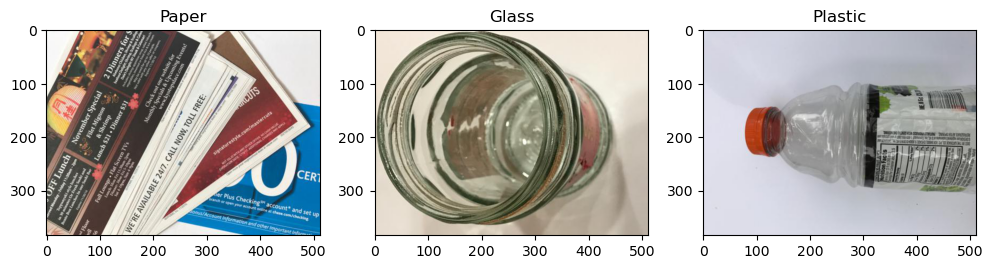

In [2]:
paper = "./archive/garbage_classification/images/paper/paper100.jpg"
glass = "./archive/garbage_classification/images/glass/glass21.jpg"
plastic = "./archive/garbage_classification/images/plastic/plastic21.jpg"

img_paper = Image.open(paper)
img_glass = Image.open(glass)
img_plastic = Image.open(plastic)

plt.figure(figsize=(12,12))
plt.subplot(1, 3, 1)
plt.imshow(img_paper)
plt.axis("on")
plt.title("Paper")

plt.subplot(1, 3, 2)
plt.imshow(img_glass)
plt.axis("on")
plt.title("Glass")

plt.subplot(1, 3, 3)
plt.imshow(img_plastic)
plt.axis("on")
plt.title("Plastic")
plt.show()

Picture's path for each classe.

In [3]:
glass= "./archive/garbage_classification/images/glass/"
paper= "./archive/garbage_classification/images/paper/"
plastic=  "./archive/garbage_classification/images/plastic/"

dict = {}
dict[0] = 'glass'
dict[1] = 'plastic'
dict[2] = 'paper'

## Data Preparation

The dataset is not balanced. Using the data as it is is will probably show wrong results and we may suffer of Overfitting. This means that we need to do some pre processing in order to be able to make conclusions.

Glass: 31.761 % 
Paper: 37.676 % 
Plastic: 30.563 % 


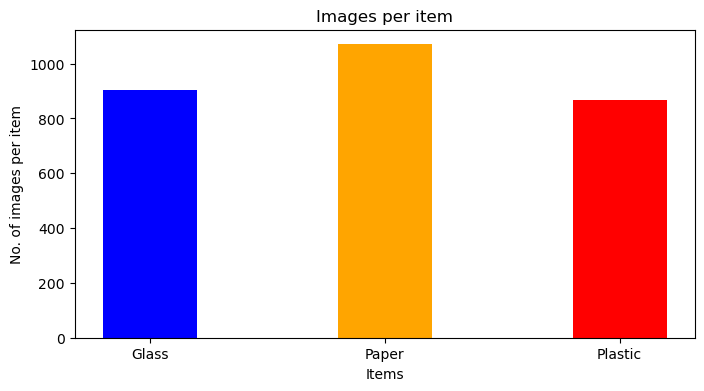

In [4]:
glass_items=902
paper_items=1070
plastic_items=868

print('Glass:', round(glass_items/(glass_items+paper_items+plastic_items) * 100,3), '% ')
print('Paper:', round(paper_items/(glass_items+paper_items+plastic_items) * 100,3),'% ')
print('Plastic:', round(plastic_items/(glass_items+paper_items+plastic_items) * 100,3),'% ')

data = {'Glass': glass_items, 'Paper': paper_items, 'Plastic': plastic_items}
items = list(data.keys())
values = list(data.values())

fig = plt.figure(figsize = (8, 4))

plt.bar(items[0], values[0], color ='blue',width = 0.4)
plt.bar(items[1], values[1], color ='orange',width = 0.4)
plt.bar(items[2], values[2], color ='red',width = 0.4)

plt.xlabel("Items")
plt.ylabel("No. of images per item")
plt.title("Images per item")
plt.show()

In order of the results above we decided to balance the dataset and only use the same number of images of each classe.

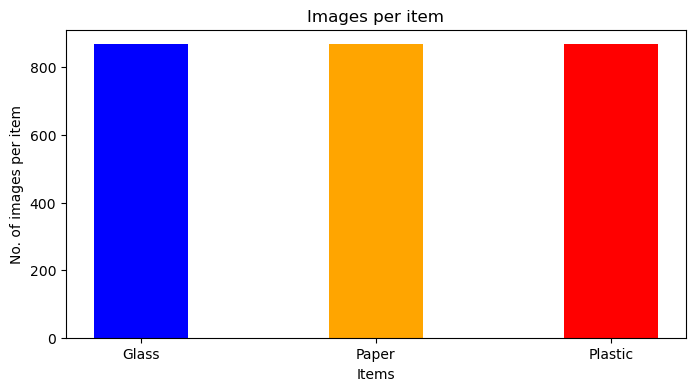

In [5]:
num_images=868 # 868 beacause it is the lowest number from the three classes

data = {'Glass': num_images, 'Paper': num_images, 'Plastic': num_images}
items = list(data.keys())
values = list(data.values())

fig = plt.figure(figsize = (8, 4))

plt.bar(items[0], values[0], color ='blue',width = 0.4)
plt.bar(items[1], values[1], color ='orange',width = 0.4)
plt.bar(items[2], values[2], color ='red',width = 0.4)

plt.xlabel("Items")
plt.ylabel("No. of images per item")
plt.title("Images per item")
plt.show()

In order to make more easy and lower the number of features we decided to resize each image, beacuse initially the lower size was 512*384 which leads to a higher number of features.

In [6]:
img_size = 64
train_images = []

for p in range(1,num_images+1):
    image = Image.open(glass+"glass"+str(p)+".jpg")
    image = image.resize((img_size, img_size))
    #image = image.convert(mode="L")
    train_images.append(image)

for p in range(1,num_images+1):
    image = Image.open(plastic+"plastic"+str(p)+".jpg")
    image = image.resize((img_size, img_size))
    #image = image.convert(mode="L")
    train_images.append(image)

for p in range(1,num_images+1):
    image = Image.open(paper+"paper"+str(p)+".jpg")
    image = image.resize((img_size, img_size))
    #image = image.convert(mode="L")
    train_images.append(image)

## Data Normalization

In [33]:
X = np.empty((num_images*3, 64,64,3))
index = 0
for pl in train_images:
    # Normalize pixel values
    pixels = asarray(pl)
    pixels = pixels.astype('float32')
    pixels /= 255.0
    X[index] = pixels
    index += 1
g = np.zeros(num_images)
m = np.ones(num_images)
p = np.empty(num_images)
p.fill(2)
y = np.concatenate((g, m, p), axis=0).reshape(X.shape[0], 1)

y = y.reshape(-1,)

print("X shape: ", X.shape)
print("y shape: ", y.shape)

# different shape from previous work
print(X[0].shape)

X shape:  (2604, 64, 64, 3)
y shape:  (2604,)
(64, 64, 3)


(64, 64, 3)
(64, 64, 3)
(64, 64, 3)


Text(0.5, 1.0, 'paper')

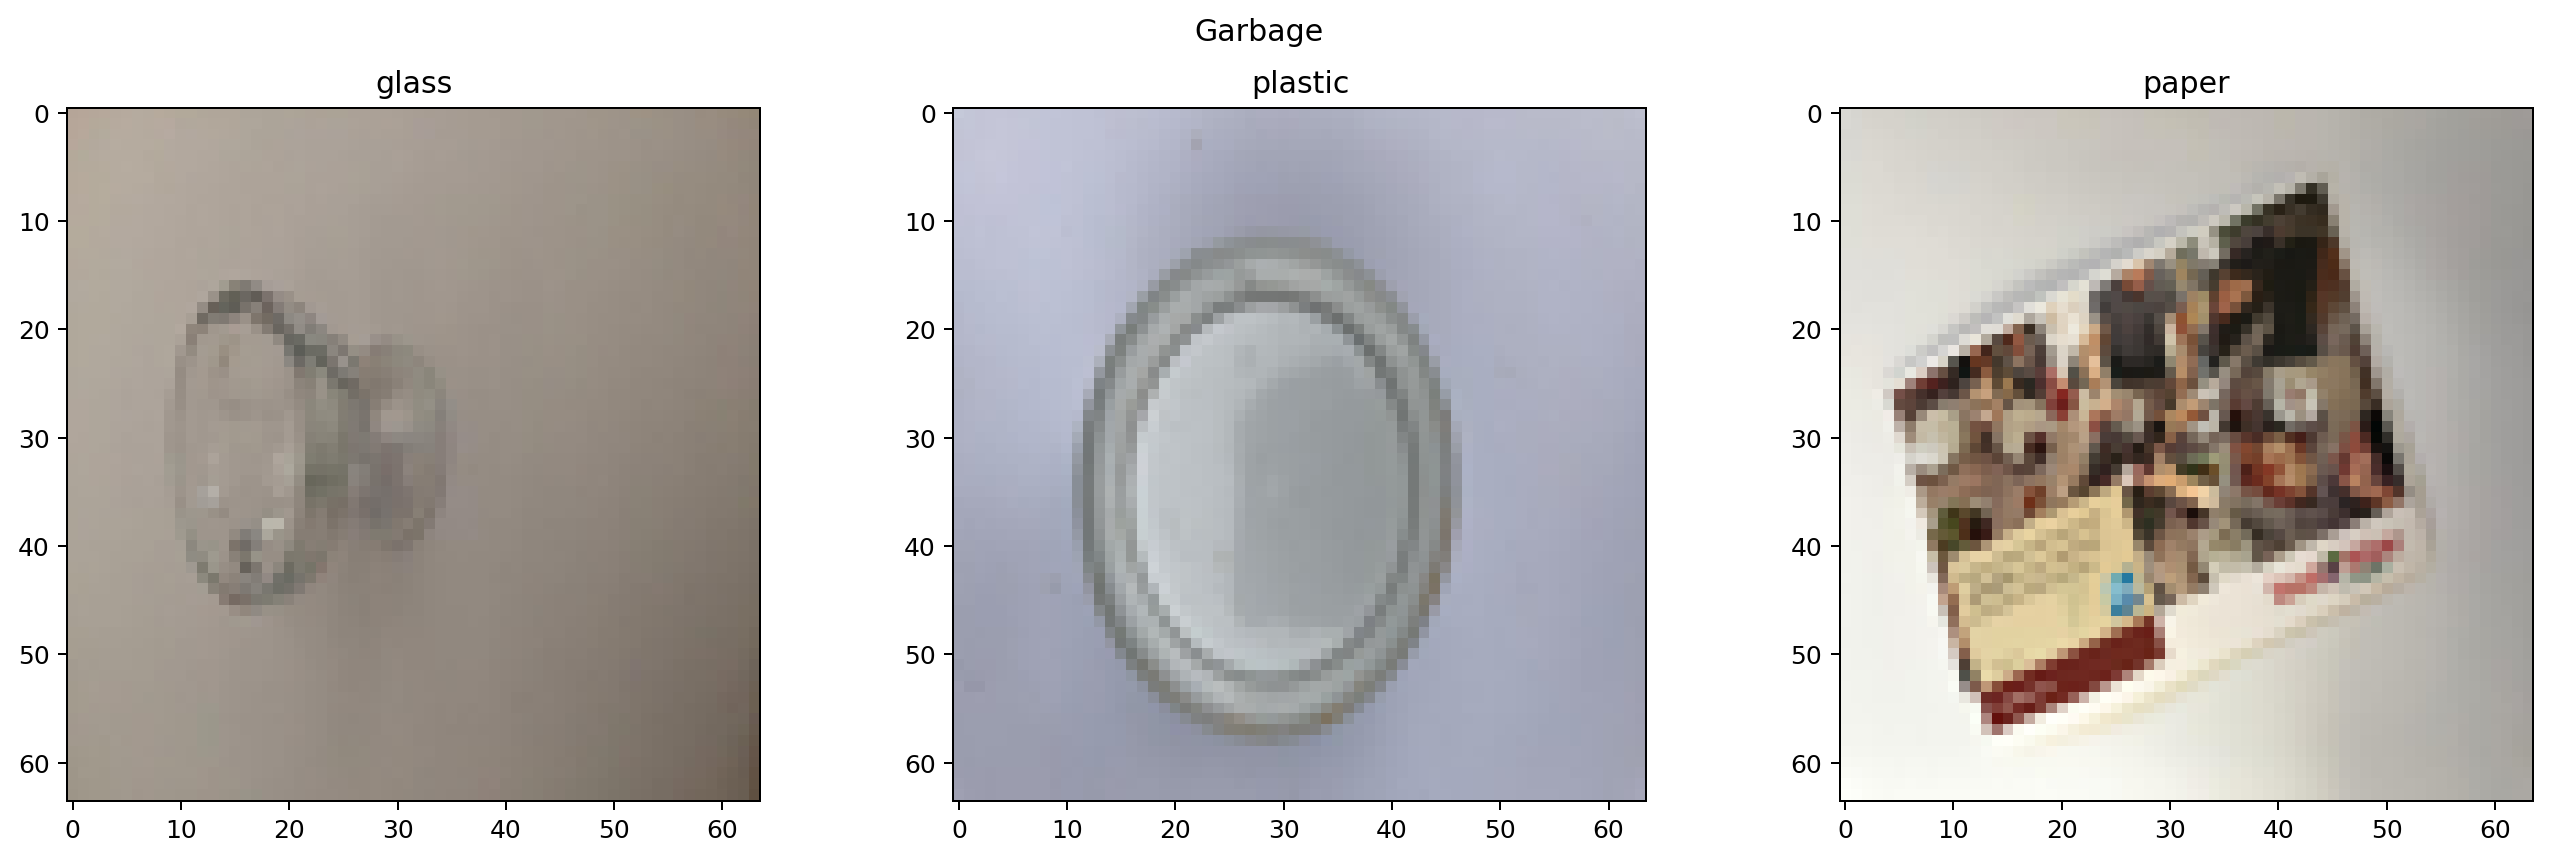

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5), dpi=180)
fig.suptitle('Garbage')

print(X[1].shape)
axs[0].imshow(X[1])
axs[0].set_title("glass")

print(X[900].shape)
axs[1].imshow(X[900])
axs[1].set_title("plastic")

print(X[1800].shape)
axs[2].imshow(X[1800])
axs[2].set_title("paper")

Splitting the dataset into training subset and testing subset, using 20% fo the dataset to test

(2083, 64, 64, 3)
(2604, 64, 64, 3)
X train shape: (2083, 64, 64, 3)
X train length: 2083
y train shape: (2083, 3)
y train length: 2083

X test shape: (521, 64, 64, 3)
X test length: 521
y test shape: (521, 3)
y test length: 521


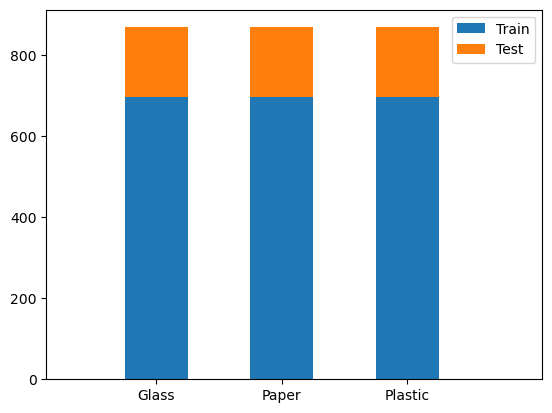

In [9]:
from keras.utils import to_categorical

# to categorical
y = to_categorical(y)

# extract train sub-set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"X train shape: {X_train.shape}")
print(f"X train length: {len(X_train)}")
print(f"y train shape: {y_train.shape}")
print(f"y train length: {len(y_train)}")
print()
print(f"X test shape: {X_test.shape}")
print(f"X test length: {len(X_test)}")
print(f"y test shape: {y_test.shape}")
print(f"y test length: {len(y_test)}")

 
labels = ['Glass', 'Paper', 'Plastic']
y1 = [695, 695, 695]
y2 = [173, 173, 173]
width = 0.5       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()

ax.bar(labels, y1, width, label='Train')
ax.bar(labels, y2, width, bottom=y1,
       label='Test')

#ax.set_ylabel('')
#ax.set_title('')
ax.legend()
xmin, xmax = ax.get_xlim()
ax.set_xlim(xmin - 0.5, xmax + 0.7)

plt.show()

# Deep Learning

In [27]:
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Input
from keras.optimizers import Adam
from sklearn import preprocessing

def model_training(model, model_name, X_train, y_train, X_test, y_test, epochs = 2, batch_size=32):
    model.fit(X_train, y_train, epochs = epochs, batch_size = batch_size)
    
    y_hat = model.predict(X_test)
    
    return accuracy_score(y_test, y_hat)

def model_analysis(model, X_train, y_train, X_test, y_test, history):

    print(f"> Model: {model.__class__}\n")
    classes = ['glass', 'plastic', 'paper']
    y_pred=model.predict(X_test)
    print(y_pred.shape)
    print(y_test.shape)
    pred = []
    for j in y_pred:
        greater = j[0]
        index = 0
        for y in range(1,3):
            if greater < j[y]:
                greater = j[y]
                index = y
        pred.append(index)
    y_pred = pred
    y_test=np.argmax(y_test,axis=1)
    test_data_accuracy = accuracy_score(y_pred, y_test)
    f1 = f1_score(y_test, y_pred, average = 'macro')

    print()
    print("------ Model Analysis ------")
    print('Accuracy: ', test_data_accuracy)
    print('F1 Score: ', f1)
    
    print()
    print("------- Classification Report -------")
    print( classification_report(y_test, y_pred) )
    
    print()
    print("------ Confusion Matrix ------")

    con_mat = tf.math.confusion_matrix(labels=y_test, predictions=y_pred).numpy()
    
    con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

    con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes, 
                     columns = classes)
    
    figure = plt.figure(figsize=(6, 5))
    sns.heatmap(con_mat_df, annot=True)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

    print()
    print("------ Graphical Analysis ------")

    # Plot the accuracy and loss
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

In [25]:
input_img = Input(shape=(img_size, img_size, 3))

x_val = X_train[:5000]
y_val = y_train[:5000]

print(X_train.shape)
print(y_train.shape)

model = Sequential() #step 1
model.add(Conv2D(filters = 16, kernel_size = 2,input_shape=(64,64,3),padding='same')) #step2
model.add(Activation('relu'))  # step3
model.add(MaxPooling2D(pool_size=2)) #step4
model.add(Conv2D(filters = 32,kernel_size = 2,activation= 'relu',padding='same')) #repeating step 2 and step3 but with more filters of 32
model.add(MaxPooling2D(pool_size=2)) #repeating step 4 again
model.add(Conv2D(filters = 64,kernel_size = 2,activation= 'relu',padding='same')) #repeating step 2 and step3 but with more filters of 64
model.add(MaxPooling2D(pool_size=2)) #repeating step 4 again
model.add(Conv2D(filters = 128,kernel_size = 2,activation= 'relu',padding='same')) #repeating step 2 and step3 but with more filters of 64
model.add(MaxPooling2D(pool_size=2)) #repeating step 4 again
model.add(Dropout(0.3)) # step5
model.add(Flatten()) #step 6
model.add(Dense(150)) #step 7
model.add(Activation('relu')) # step 3
model.add(Dropout(0.4)) # step 5
model.add(Dense(3,activation = 'softmax'))

# Compile the model
# model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, batch_size=32, epochs=35, validation_data=(x_val, y_val), verbose=2, shuffle=True)

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc:.3f}')

# Use the model to classify new images
predictions = model.predict(X_test)

(2083, 64, 64, 3)
(2083, 3)
Train on 2083 samples, validate on 2083 samples
Epoch 1/35
 - 5s - loss: 1.0783 - accuracy: 0.4042 - val_loss: 1.0159 - val_accuracy: 0.4772
Epoch 2/35
 - 3s - loss: 0.9456 - accuracy: 0.5468 - val_loss: 1.1632 - val_accuracy: 0.4378
Epoch 3/35
 - 3s - loss: 0.8321 - accuracy: 0.6241 - val_loss: 0.7227 - val_accuracy: 0.6798
Epoch 4/35
 - 3s - loss: 0.7581 - accuracy: 0.6803 - val_loss: 0.6698 - val_accuracy: 0.6908
Epoch 5/35
 - 3s - loss: 0.6646 - accuracy: 0.7235 - val_loss: 0.6817 - val_accuracy: 0.6980
Epoch 6/35
 - 3s - loss: 0.6331 - accuracy: 0.7360 - val_loss: 0.5219 - val_accuracy: 0.7878
Epoch 7/35
 - 3s - loss: 0.5717 - accuracy: 0.7619 - val_loss: 0.5470 - val_accuracy: 0.7796
Epoch 8/35
 - 3s - loss: 0.5204 - accuracy: 0.7873 - val_loss: 0.6613 - val_accuracy: 0.7307
Epoch 9/35
 - 3s - loss: 0.4744 - accuracy: 0.8070 - val_loss: 0.7258 - val_accuracy: 0.6625
Epoch 10/35
 - 3s - loss: 0.4680 - accuracy: 0.8108 - val_loss: 0.8035 - val_accuracy: 

> Model: <class 'keras.engine.sequential.Sequential'>

(521, 3)
(521, 3)

------ Model Analysis ------
Accuracy:  0.9385796545105566
F1 Score:  0.9388543583113719

------- Classification Report -------
              precision    recall  f1-score   support

           0       0.92      0.93      0.93       181
           1       0.90      0.96      0.93       164
           2       1.00      0.92      0.96       176

    accuracy                           0.94       521
   macro avg       0.94      0.94      0.94       521
weighted avg       0.94      0.94      0.94       521


------ Confusion Matrix ------


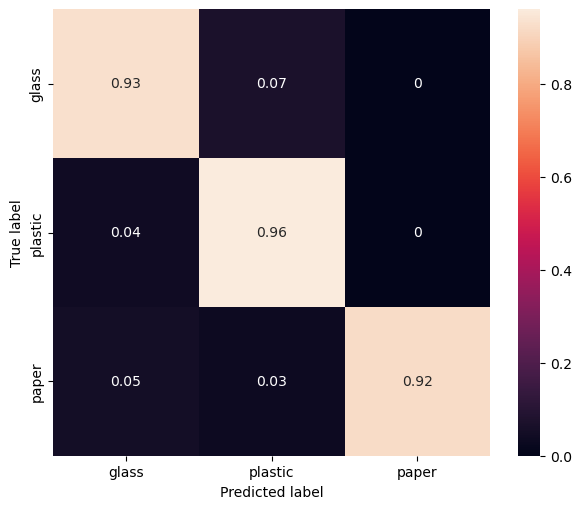


------ Graphical Analysis ------


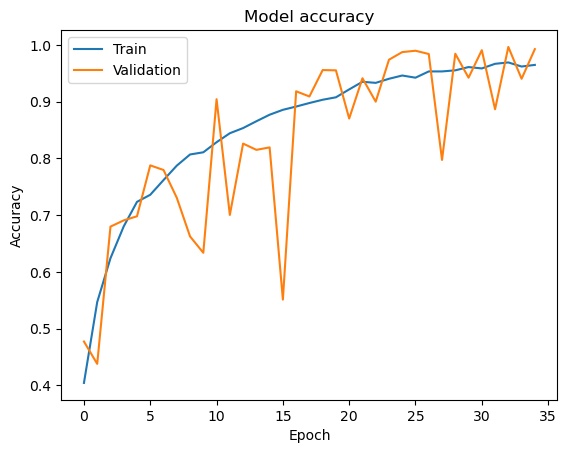

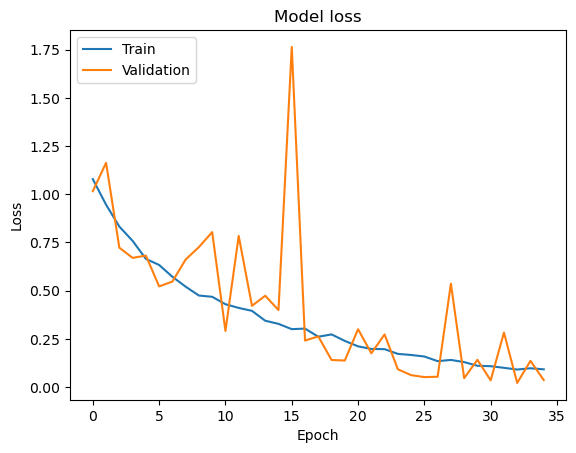

In [28]:
model_analysis(model, X_train, y_train, X_test, y_test, history)

# ResNet

In [ ]:
from tensorflow import keras
import tensorflow as tf
from keras.preprocessing import image
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras import optimizers
import numpy as np

# Create the base pre-trained model
base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False)

# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(3, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='adamax', loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the model on the training data
history = model.fit(X_train, y_train, batch_size=32,
                                epochs=40,
                                validation_data=(X_test, y_test))

# Plot the accuracy and loss
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Models Comparison

We are using a box plot to display and compare the results from the models.

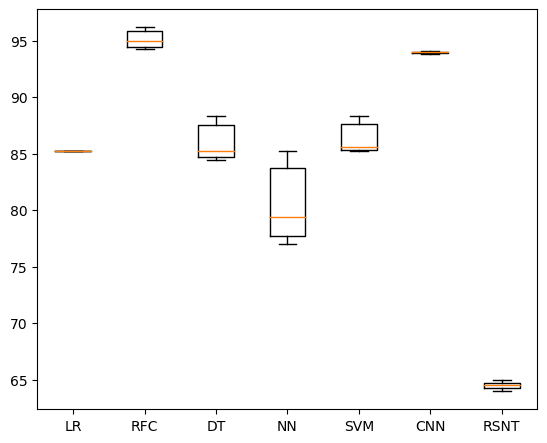

In [31]:
LR = [85.22, 85.22, 85.22]
RFC = [95.01, 94.24, 96.16, 94.99, 94.25, 96.16]
DT = [88.29, 85.22, 84.45, 88.35, 85.31, 84.55]
NN = [85.22, 79.46, 77.16, 85.20, 79.39, 77.04]
SVM = [85.60, 88.30, 85.22, 85.59, 88.27, 85.22]
CNN = [94.04, 94.02, 93.85, 93.88]
RSNT = [65, 64]

data = [LR, RFC, DT, NN, SVM, CNN, RSNT]

fig = plt.figure(figsize =(5, 4))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
 
# Creating plot
bp = ax.boxplot(data, labels=["LR", "RFC", "DT", "NN", "SVM", "CNN", "RSNT"])
 
# show plot
plt.show()